## Regression  (Linear and KNN)`

### Importing Required Libraries

In [37]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

from scipy.stats import shapiro, kstest, normaltest, skew
# from scipy.stats.api import qqplot

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import json
import pickle

import config


## 1. Problem Statment

 Problem Statment :
    To predict the Medical insurance charges using following features:
    age, gender, bmi, children, smoker, region, charges

## 2. Data Gathering

In [38]:
df = pd.read_csv(config.CSV_FILE_PATH)
df

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## 3. Exploratory Data Analysis (EDA)

In [39]:
df.isna().sum()         # No missing values in our dataset

age         0
gender      0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### No Missing VAlues

In [40]:
df.info()    # Datatypes of some feature is object, so use encoding.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [41]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


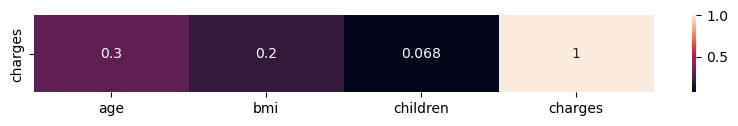

In [42]:
plt.figure(figsize=(10,1))
sns.heatmap(df.corr().tail(1), annot=True)
plt.show()

### Feature Engineering

#### Encoding

In [43]:
df.gender.value_counts().to_dict()    # for categorical column, replace the higher count(male:676) with 1 and lower with 0
   

{'male': 676, 'female': 662}

In [44]:
df.smoker.value_counts().to_dict()

{'no': 1064, 'yes': 274}

In [45]:
df['gender'] = df['gender'].replace({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].replace({'no': 0, 'yes': 1})

In [46]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [47]:
df1 = pd.get_dummies(df, columns=['region'])
df1

,age,gender,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,1


#### Check for outliers

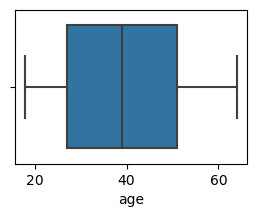

In [48]:
plt.figure(figsize=(3,2))
sns.boxplot(x = df1['age'])
plt.show()

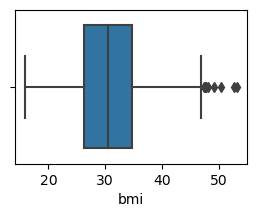

In [49]:
plt.figure(figsize=(3,2))         
sns.boxplot(x = df1['bmi'])
plt.show()

In [50]:
# here outliers are present near upper tail side... so replace the outliers with upper tail

q1,q3 = np.quantile(df1['bmi'],[0.25,0.75])    
iqr = q3 - q1

upper_tail = q3 + 1.5*iqr
upper_tail

df1['bmi'] = np.where(df1['bmi'] > upper_tail, upper_tail, df1['bmi'])

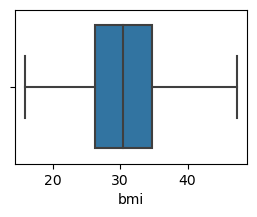

In [51]:
plt.figure(figsize=(3,2))    # No outliers
sns.boxplot(x = df1['bmi'])
plt.show()

In [52]:
df1.head()

,age,gender,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### Feature SCaling

In [53]:
x = df1.drop('charges', axis = 1)   # Here we use normal scaler because 

normal_scaler = MinMaxScaler()
array = normal_scaler.fit_transform(x)
dfx = pd.DataFrame(array, columns= x.columns)

In [54]:
dfx.head()

,age,gender,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.0,0.381104,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.568465,0.2,0.0,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.543888,0.6,0.0,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.215289,0.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.412384,0.0,0.0,0.0,1.0,0.0,0.0


### Model Training

### 1. Linear Regression

In [55]:
# without scaling
x = df1.drop('charges', axis = 1)
y = df1['charges']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=14)

linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)

LinearRegression()

In [56]:
### Evaluation of linear Regression

train_score = linear_reg.score(x_train, y_train)
print("Training R-squared Value : ", train_score)

test_score = linear_reg.score(x_test, y_test)
print("Testing R-squared Value : ", test_score)

Training R-squared Value :  0.7558879040413119
Testing R-squared Value :  0.7291648562498081


In [57]:
# with scaling

x_train, x_test, y_train, y_test = train_test_split(dfx,y, test_size=0.2, random_state=14)

linear_reg_scale = LinearRegression()
linear_reg_scale.fit(x_train, y_train)

LinearRegression()

In [58]:
### Evaluation of linear Regression

train_score = linear_reg_scale.score(x_train, y_train)
print("Training R-squared Value : ", train_score)

test_score = linear_reg_scale.score(x_test, y_test)
print("Testing R-squared Value : ", test_score)

Training R-squared Value :  0.7558771683280103
Testing R-squared Value :  0.7294138747866501


### 2. KNN regression

In [59]:
# Without scaling
x = df1.drop('charges', axis = 1)
y = df1['charges']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=30)

knn_reg = KNeighborsRegressor(n_neighbors=5, p = 2)
knn_reg.fit(x_train, y_train)

KNeighborsRegressor()

In [60]:
### Evaluation of linear Regression

train_score = knn_reg.score(x_train, y_train)
print("Training R-squared Value : ", train_score)

test_score = knn_reg.score(x_test, y_test)
print("Testing R-squared Value : ", test_score)

Training R-squared Value :  0.44804668308133444
Testing R-squared Value :  0.13631753060465068


In [61]:
# With scaling

x = df1.drop('charges', axis = 1)
y = df1['charges']

x_train, x_test, y_train, y_test = train_test_split(dfx,y, test_size=0.2, random_state=14)

knn_reg_scale = KNeighborsRegressor(n_neighbors=5, p = 2)
knn_reg_scale.fit(x_train, y_train)

KNeighborsRegressor()

In [62]:
### Evaluation of linear Regression

train_score = knn_reg_scale.score(x_train, y_train)
print("Training R-squared Value : ", train_score)

test_score = knn_reg_scale.score(x_test, y_test)
print("Testing R-squared Value : ", test_score)

Training R-squared Value :  0.8579299434207222
Testing R-squared Value :  0.7727234506892107


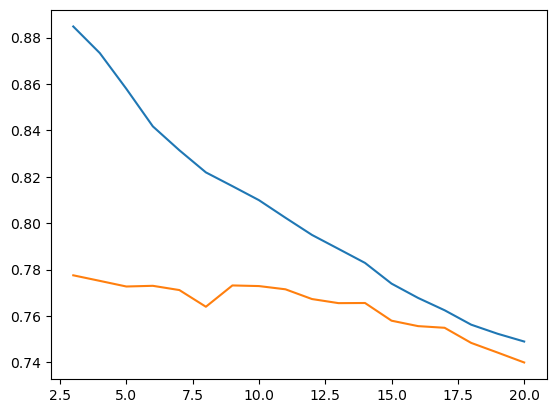

In [63]:
#  find best value of p = 2 and k

train_acc_list = []
test_acc_list = []
k_value = np.arange(3,21)

for k in k_value:
    knn_reg = KNeighborsRegressor(k, p = 2)
    knn_reg.fit(x_train, y_train)
    
    train_acc = knn_reg.score(x_train, y_train)
    train_acc_list.append(train_acc)
    
    test_acc = knn_reg.score(x_test, y_test)
    test_acc_list.append(test_acc)
    
plt.plot(k_value, train_acc_list)
plt.plot(k_value, test_acc_list)
plt.show()

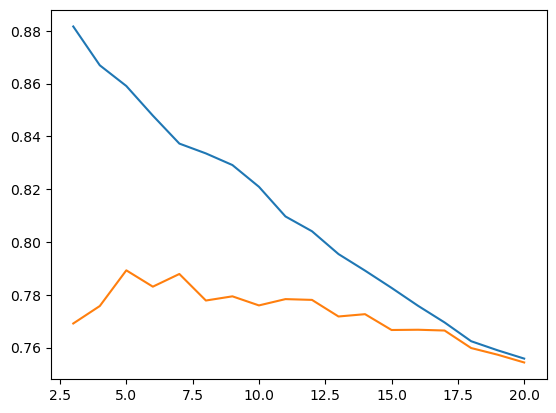

In [64]:
#  find best value of p = 1 and k

train_acc_list = []
test_acc_list = []
k_value = np.arange(3,21)

for k in k_value:
    knn_reg = KNeighborsRegressor(k, p = 1)
    knn_reg.fit(x_train, y_train)
    
    train_acc = knn_reg.score(x_train, y_train)
    train_acc_list.append(train_acc)
    
    test_acc = knn_reg.score(x_test, y_test)
    test_acc_list.append(test_acc)
    
plt.plot(k_value, train_acc_list)
plt.plot(k_value, test_acc_list)
plt.show()

In [65]:
knn_reg_scale = KNeighborsRegressor(n_neighbors= 9, p = 2)   # best value p = 2, k = 9
knn_reg_scale.fit(x_train, y_train)

train_score = knn_reg_scale.score(x_train, y_train)
print("Training R-squared Value : ", train_score)

test_score = knn_reg_scale.score(x_test, y_test)
print("Testing R-squared Value : ", test_score)

Training R-squared Value :  0.8159707958357769
Testing R-squared Value :  0.7731794427218288


### Save Required file

### 1. Model

In [66]:
model = [linear_reg_scale, knn_reg_scale]

with open(r'artifacts/Model.pkl', 'wb') as f:
    pickle.dump(model,f)


### 2. Save Column Names

In [67]:
column_names = x.columns
project_data = {'Column Names' : column_names.tolist(),
               'Gender' : {'male': 1, 'female': 0},
               'Smoker' : {'no': 0, 'yes': 1}
               }

with open(r'artifacts/project_data.json', 'w') as f:
    json.dump(project_data,f)

### 3. Save Scaler

In [68]:
with open(r'artifacts/normal_scaler.pkl', 'wb') as f:
    pickle.dump(normal_scaler, f)


In [69]:
with open(r'artifacts/Model.pkl', 'rb') as f:
    model_reg = pickle.load(f)
    
model_reg[0].n_features_in_

9

In [70]:
test_array = np.array([model[0].n_features_in_])
test_array[0]
# model[0][0].n_features_in_

9

In [71]:
test_array = np.zeros((1, model[0].n_features_in_))
test_array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [72]:
df1

,age,gender,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,0,1
